In [1]:
#@title Code Lines with Header Styling
from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
@register_line_magic
def cmap_header(params):
    params=params.split('|'); string=params[0]
    if len(params)==1: 
        font_size='30'; font_family='Smokum'; cmap='Sinebow'
    elif  len(params)==2: 
        font_size=params[1]; font_family='Smokum'; cmap='Sinebow'
    elif  len(params)==3: 
        font_size=params[1]; font_family=params[2]; cmap='Sinebow'
    else: 
        font_size=params[1]; font_family=params[2]; cmap=params[3]
    html_str="""
    <head><script src='https://d3js.org/d3.v6.min.js'></script></head>
    <style>@import 'https://fonts.googleapis.com/css?family="""+\
    font_family+"""&effect=3d'; #colorized {font-family:"""+font_family+"""; 
    color:white; padding-left:10px; font-size:"""+font_size+"""px;}</style>
    <h1 id='colorized' class='font-effect-3d'>"""+string+"""</h1>
    <script>
    var tc=setInterval(function(){
        var now=new Date().getTime();
        var iddoc=document.getElementById('colorized');
        iddoc.style.color=d3.interpolate"""+cmap+"""(now%(60000)/60000);},1)
    </script>"""
    display(HTML(html_str))

In [2]:
%cmap_header Code Modules, Settings & Functions

In [3]:
!python3 -m pip install --upgrade pip \
--user --quiet --no-warn-script-location
!python3 -m pip install --upgrade \
neural_structured_learning --user --quiet 

In [4]:
import os,h5py,urllib,pandas as pd,numpy as np
import tensorflow as tf,pylab as pl,seaborn as sn
import neural_structured_learning as nsl
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
file_path='https://raw.githubusercontent.com/'+\
          'OlgaBelitskaya/data_kitchen/main/'
file_name='Pictograms64.h5'
img_size=64
model_weights='/checkpoints'

In [5]:
def pd_style():
    return [dict(selector='th',
                 props=[('font-size','12pt'),('min-width','150px')]),
            dict(selector='td',
                 props=[('padding','0em 0em'),('min-width','150px')]),
            dict(selector='tr:hover th:hover',
                 props=[('font-size','14pt'),('max-width','150px'),
                        ('text-shadow','3px 3px 3px #aaa')]),
            dict(selector='tr:hover td:hover',
                 props=[('font-size','12pt'),('max-width','150px'),
                        ('text-shadow','3px 3px 3px #aaa')])]

In [6]:
def h5file2data(h5file,img_size,
                resize=True,cmap='tab20',fig_size=7):
    with h5py.File(h5file,'r') as f:
        keys=list(f.keys()); print('file keys: '+', '.join(keys))
        images=np.array(f[keys[int(0)]],dtype='float32')
        labels=np.array(f[keys[int(1)]],dtype='float32')
        names=[[el.decode('utf-8') for el in f[keys[i]]]
               for i in range(2,len(keys))]
        f.close()
    N=images.shape[0]; n=int(.1*N)
    if resize:
        images=tf.image.resize(images,[img_size,img_size]).numpy()
    shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    images=images[shuffle_ids]
    labels=np.array([labels[i][shuffle_ids] 
                     for i in range(labels.shape[0])])
    x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
    y_test,y_valid,y_train=labels[:,:n],labels[:,n:2*n],labels[:,2*n:]
    df=pd.DataFrame(
        [[x_train.shape,x_valid.shape,x_test.shape],
         [x_train.dtype,x_valid.dtype,x_test.dtype],
         [y_train.shape,y_valid.shape,y_test.shape],
         [y_train.dtype,y_valid.dtype,y_test.dtype]],
        columns=['train','valid','test'],
        index=['image shape','image type','label shape','label type'])
    print('data outputs: ')
    display(df.style.set_table_styles(pd_style()))
    print('distribution of labels: ')
    idx=['labels %d'%(i+1) for i in range(labels.shape[0])]
    df=pd.DataFrame(labels,index=idx).T
    for i in range(labels.shape[0]):
        df['name %d'%(i+1)]=[names[i][int(l)] for l in labels[i]]
    fig=pl.figure(figsize=(1.5*fig_size,fig_size))    
    for i in range(labels.shape[0]):
        ax=fig.add_subplot(labels.shape[0],1,i+1)
        sn.countplot(x='name %s'%(i+1),data=df,palette=cmap,alpha=.5,ax=ax)
    pl.tight_layout(); pl.show()       
    return [names,x_train,x_valid,x_test,y_train,y_valid,y_test]

In [7]:
def display_images(images,labels,names,n):
    fig=pl.figure(figsize=(9,n/2))
    randch=np.random.choice(images.shape[0],size=n,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(int(n//5)+1,5,i+1,xticks=[],yticks=[])
        ax.imshow(images[idx],cmap='bone')
        label=[labels[:,idx]]
        name=[names[i][int(labels[i][idx])] 
              for i in range(labels.shape[0])]
        ti='{} \n {}'.format(str(label),str(name))
        ax.set_title(ti,fontsize=8)
    pl.tight_layout(); pl.show()

In [8]:
def cb(mw):
    early_stopping=tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=20,verbose=2,mode='max')
    checkpointer=tf.keras.callbacks.ModelCheckpoint(
        save_best_only=True,save_weights_only=True,
        monitor='val_sparse_categorical_accuracy',
        filepath=mw,verbose=2,mode='max')
    lr_reduction=tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_scaled_adversarial_loss',
        verbose=2,patience=10,factor=.8,mode='min')
    return [checkpointer,early_stopping,lr_reduction]

In [9]:
def keras_history_plot(
    fit_history,fig_size=9,color='darkblue'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size))
    ax1=fig.add_subplot(3,1,1)
    dfkeys.iloc[:,[0,4]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(3,1,2)
    dfkeys.iloc[:,[3,7]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    ax3=fig.add_subplot(3,1,3)
    dfkeys.iloc[:,[2,6]].plot(
        ax=ax3,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()

In [10]:
%cmap_header Data Loading

file keys: images, labels, names1, names2
data outputs: 


,train,valid,test
image shape,"(2837, 64, 64, 3)","(354, 64, 64, 3)","(354, 64, 64, 3)"
image type,float32,float32,float32
label shape,"(2, 2837)","(2, 354)","(2, 354)"
label type,float32,float32,float32


distribution of labels: 


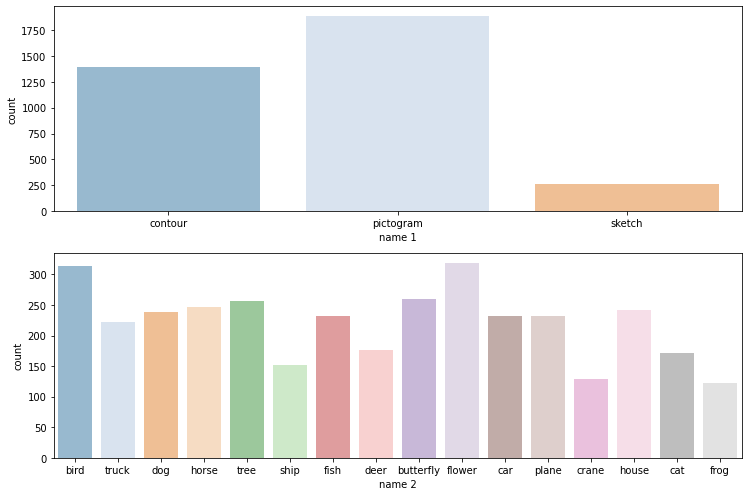

In [11]:
input_file=urllib.request.urlopen(file_path+file_name)
output_file=open(file_name,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
[names,x_train,x_valid,x_test,y_train,y_valid,y_test]=\
h5file2data(file_name,img_size)
num_classes=len(names[1])
os.remove(file_name)

In [12]:
%cmap_header TF Data Processing

In [13]:
batch_size=16
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,
     'label':np.array(y_train[1],dtype='float32')}).batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,
     'label':np.array(y_valid[1],dtype='float32')}).batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size

In [14]:
set(y_train[1])

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0}

In [16]:
%cmap_header Models with Adversarial Regularization => MLP

In [17]:
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size,3),name='input'),
    tkl.Flatten(),
    tkl.Dense(192,activation=tf.nn.relu),
    tkl.BatchNormalization(),    
    tkl.Dense(256,activation=tf.nn.relu),
    tkl.BatchNormalization(),    
    tkl.Dense(512,activation=tf.nn.relu),
    tkl.Dense(num_classes,activation=tf.nn.softmax)
])
adv_config=nsl.configs.make_adv_reg_config(
    multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras.AdversarialRegularization(
    base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')

In [18]:
history=adv_model.fit(
    train,validation_data=valid,verbose=2,
    validation_steps=valid_steps,
    epochs=100,callbacks=cb(model_weights));

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


178/178 - 22s - loss: 2.8474 - sparse_categorical_crossentropy: 2.3652 - sparse_categorical_accuracy: 0.2700 - scaled_adversarial_loss: 0.4822 - val_loss: 4.1786 - val_sparse_categorical_crossentropy: 3.4770 - val_sparse_categorical_accuracy: 0.1960 - val_scaled_adversarial_loss: 0.7016
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.19602, saving model to /checkpoints
Epoch 2/100
178/178 - 1s - loss: 2.1214 - sparse_categorical_crossentropy: 1.7601 - sparse_categorical_accuracy: 0.4593 - scaled_adversarial_loss: 0.3613 - val_loss: 8.6308 - val_sparse_categorical_crossentropy: 7.1821 - val_sparse_categorical_accuracy: 0.0795 - val_scaled_adversarial_loss: 1.4488

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.19602
Epoch 3/100
178/178 - 1s - loss: 1.5918 - sparse_categorical_crossentropy: 1.3170 - sparse_c

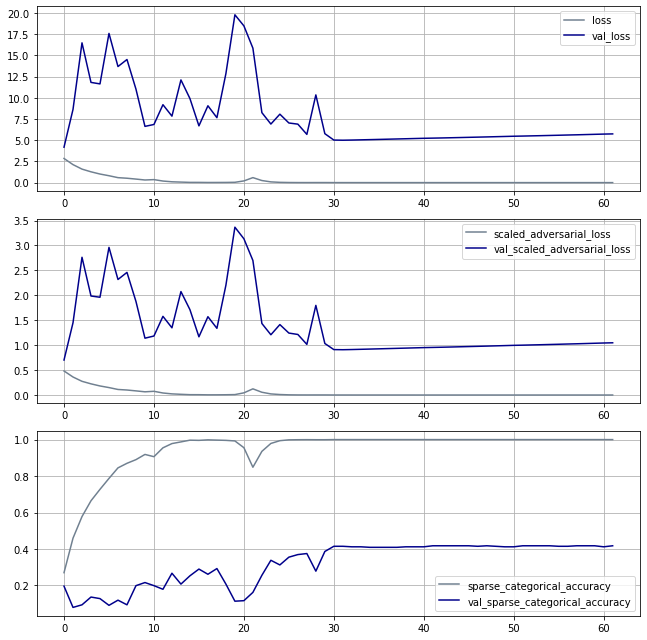

In [19]:
keras_history_plot(history)

In [20]:
adv_model.load_weights(model_weights)
dict(zip(adv_model.metrics_names,adv_model.evaluate(
    {'input':x_test,
     'label':np.array(y_test[1],dtype='float32')},
     verbose=0)))

{'loss': 5.5988311767578125,
 'scaled_adversarial_loss': 1.0182998180389404,
 'sparse_categorical_accuracy': 0.4067796468734741,
 'sparse_categorical_crossentropy': 4.580531597137451}

In [21]:
%cmap_header Models with Adversarial Regularization => CNN

In [22]:
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size,3),name='input'),
    tf.keras.layers.Conv2D(32,(5,5),padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Conv2D(196,(5,5)),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.GlobalMaxPooling2D(),    
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(num_classes,activation='softmax')
])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')

In [23]:
history=adv_model.fit(
    train,validation_data=valid,verbose=2,
    validation_steps=valid_steps,
    epochs=100,callbacks=cb(model_weights));

Epoch 1/100
178/178 - 33s - loss: 3.3146 - sparse_categorical_crossentropy: 2.7622 - sparse_categorical_accuracy: 0.0754 - scaled_adversarial_loss: 0.5523 - val_loss: 3.2775 - val_sparse_categorical_crossentropy: 2.7310 - val_sparse_categorical_accuracy: 0.1108 - val_scaled_adversarial_loss: 0.5464

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.11080, saving model to /checkpoints
Epoch 2/100
178/178 - 4s - loss: 3.2951 - sparse_categorical_crossentropy: 2.7455 - sparse_categorical_accuracy: 0.0790 - scaled_adversarial_loss: 0.5496 - val_loss: 3.2391 - val_sparse_categorical_crossentropy: 2.6988 - val_sparse_categorical_accuracy: 0.0824 - val_scaled_adversarial_loss: 0.5404

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.11080
Epoch 3/100
178/178 - 4s - loss: 3.2753 - sparse_categorical_crossentropy: 2.7283 - sparse_categorical_accuracy: 0.0832 - scaled_adversarial_loss: 0.5470 - val_loss: 3.2010 - val_sparse_categorical_crossentropy: 2.6665 -

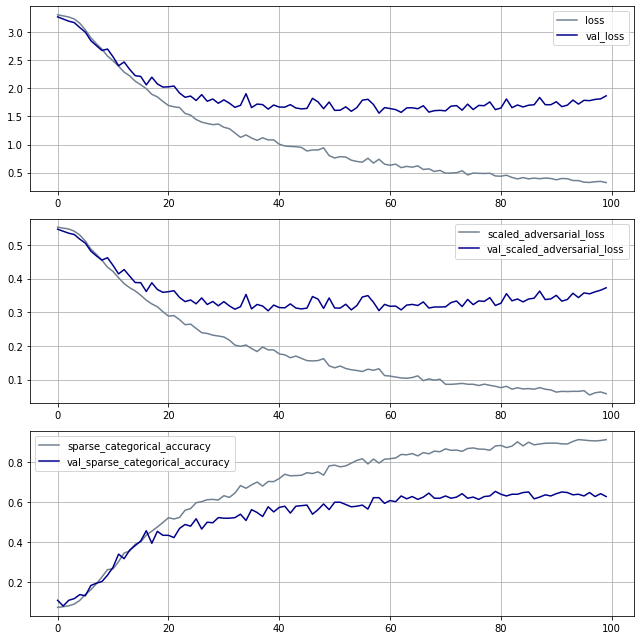

In [24]:
keras_history_plot(history)

In [25]:
adv_model.load_weights(model_weights)
dict(zip(adv_model.metrics_names,adv_model.evaluate(
    {'input':x_test,
     'label':np.array(y_test[1],dtype='float32')},
     verbose=0)))

{'loss': 1.4109368324279785,
 'scaled_adversarial_loss': 0.28080418705940247,
 'sparse_categorical_accuracy': 0.6581920981407166,
 'sparse_categorical_crossentropy': 1.1301326751708984}